In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as T
from torchvision.io import read_image
import timm
from timm import create_model

import pytorch_lightning as pl
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import LightningDataModule

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error

import glob
import gc

d:\Desktop\Programming\CZ4041-Project\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
DATA_DIR = "data"
TRAIN_DIR = "data/train"
TEST_DIR = "data/test"
OUTPUT_DIR = "output"

In [5]:
# Dataset
columns = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']

class PetFinderDataset(Dataset):
    def __init__(self, df, image_dir, image_size=224):
        self.image_ids = df["Id"].values
        self.features = df[columns].values
        self.labels = None

        if "Pawpularity" in df.keys():
            self.labels = df["Pawpularity"].values

        self.image_dir = image_dir
        self.transform = T.Resize([image_size, image_size], antialias=True)
        
    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        features = self.features[idx]

        image_id = self.image_ids[idx]
        image = read_image(os.path.join(self.image_dir, image_id + '.jpg'))
        image = self.transform(image)
        
        if self.labels is not None:
            label = self.labels[idx]
            return image_id, features, image, label
        
        return image_id, features, image

# Data Module
class PetFinderDataModule(LightningDataModule):
    def __init__(self, df_train=None, df_val=None, df_test=None, train_dir=None, val_dir=None, test_dir=None, batch_size=64, image_size=224):
        super().__init__()
        self.df_train = df_train
        self.df_val = df_val
        self.df_test = df_test

        self.train_dir = train_dir
        self.val_dir = val_dir
        self.test_dir = test_dir

        self.batch_size = batch_size
        self.image_size = image_size

    def train_dataloader(self):
        return DataLoader(PetFinderDataset(self.df_train, self.train_dir, self.image_size), batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(PetFinderDataset(self.df_val, self.val_dir, self.image_size), batch_size=self.batch_size, shuffle=False)
    
    def test_dataloader(self):
        return DataLoader(PetFinderDataset(self.df_test, self.test_dir, self.image_size), batch_size=self.batch_size, shuffle=False) 


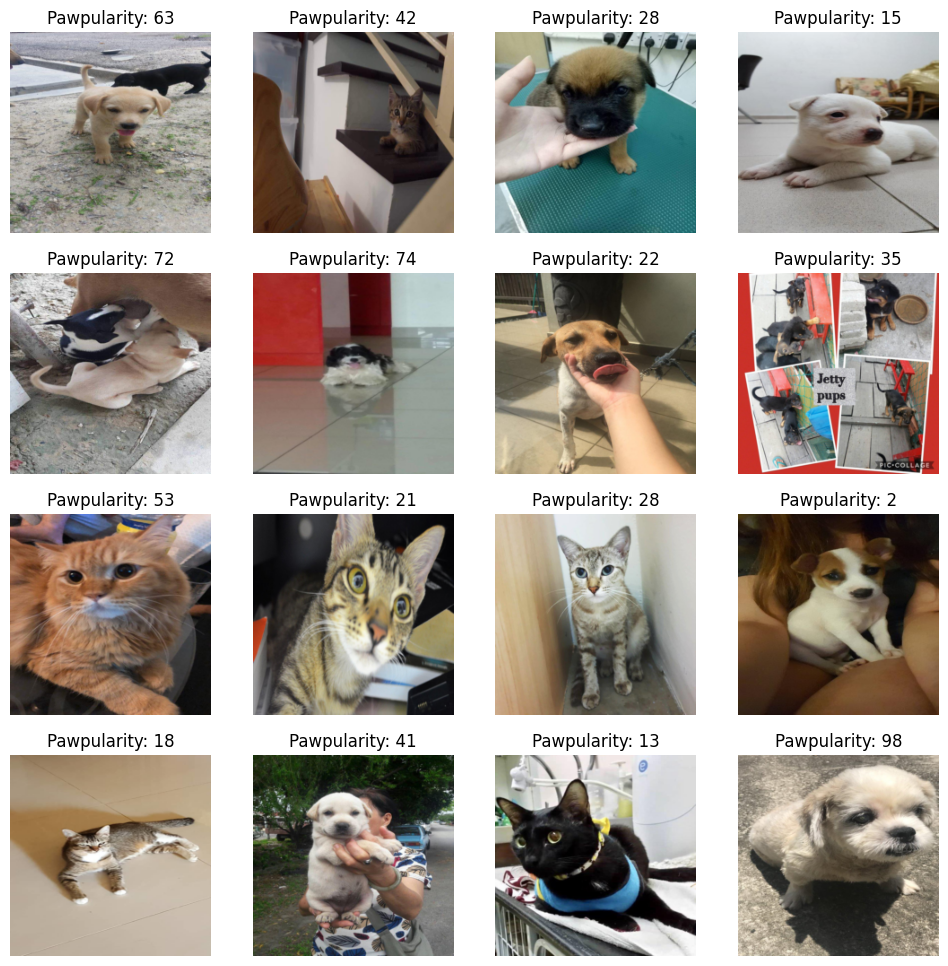

In [6]:
df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))

dataloader = PetFinderDataModule(df, df, df, train_dir=TRAIN_DIR, val_dir=TRAIN_DIR, test_dir=TEST_DIR, batch_size=64).val_dataloader()
dataiter = iter(dataloader)
image_ids, features, images, labels = next(dataiter)

n = 16
plt.figure(figsize=(12, 12))
for it, (image_id, feature, image, label) in enumerate(zip(image_ids[:n], features[:n], images[:n], labels[:n])):
    plt.subplot(4, 4, it+1)
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.title(f'Pawpularity: {int(label)}')

In [7]:
# augmentations

IMAGENET_MEAN = [0.485, 0.456, 0.406]  # RGB
IMAGENET_STD = [0.229, 0.224, 0.225]  # RGB

train_transforms = T.Compose(
    [
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.RandomAffine(15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        T.ToDtype(torch.float32, scale=True),
        T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ]
)

test_transforms = T.Compose(
    [
        T.ConvertImageDtype(torch.float),
        T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ]
)

# https://arxiv.org/abs/1710.09412v2
def mixup(x: torch.Tensor, y: torch.Tensor, alpha: float = 1.0):
    assert alpha > 0, "alpha should be larger than 0"
    assert x.size(0) > 1, "Mixup cannot be applied to a single instance."

    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size()[0])
    mixed_x = lam * x + (1 - lam) * x[rand_index, :]
    target_a, target_b = y, y[rand_index]
    return mixed_x, target_a, target_b, lam

In [8]:
class PawpularityModel(pl.LightningModule):
    def __init__(self, model_name="swin_large_patch4_window7_224", pretrained=True):
        super().__init__()
        self.validation_step_outputs = []
        self.training_step_outputs = []

        self.backbone = create_model(model_name, pretrained=pretrained, num_classes=0, in_chans=3).to('cuda')
        self.dropout = nn.Dropout(0.5)
        num_features = self.backbone.num_features

        self.fc = nn.Sequential(
            nn.Linear(num_features + len(columns), 64),
            nn.Linear(64, 1)
        )
        
        self.criterion = nn.BCEWithLogitsLoss()
        self.train_transforms = train_transforms
        self.test_transforms = test_transforms
        
    def forward(self, input, features):
        x = self.backbone(input)
        x = self.dropout(x)

        x = torch.cat([x, features], dim=1)
        x = self.fc(x)

        return x

    def step(self, batch, mode):
        image_ids, features, images, labels = batch
        labels = labels.float() / 100.0

        images = self.train_transforms(images) if mode == "train" else self.test_transforms(images)

        if torch.rand(1)[0] < 0.5 and mode == 'train' and len(images) > 1:
            mix_images, target_a, target_b, lam = mixup(images, labels, alpha=1.0)
            logits = self.forward(mix_images, features).squeeze(1)
            loss = self.criterion(logits, target_a) * lam + (1 - lam) * self.criterion(logits, target_b)
        else:
            logits = self.forward(images, features).squeeze(1)
            loss = self.criterion(logits, labels)

        predictions = logits.sigmoid().detach().cpu() * 100
        labels = labels.detach().cpu() * 100
        
        rmse = mean_squared_error(predictions, labels, squared=False) # loss uses BCELoss, while we still calculate RMSE to check
        rmse = torch.tensor(rmse, dtype=torch.float32)

        self.log(f'{mode}_loss', loss)
        
        return loss, predictions, labels, rmse

    def training_step(self, batch, batch_indexes):
        loss, predictions, labels, rmse = self.step(batch, 'train')
        self.training_step_outputs.append({ "rmse": rmse, "loss": loss })

        return { 'loss': loss, 'predictions': predictions, 'labels': labels }

    def validation_step(self, batch, batch_indexes):
        loss, predictions, labels, rmse = self.step(batch, 'val')
        self.validation_step_outputs.append({ "rmse": rmse, "loss": loss })
        
        return { 'loss': loss, 'predictions': predictions, 'labels': labels }
    
    def on_train_epoch_end(self):
        rsmes = [x["rmse"] for x in self.training_step_outputs]
        rsme = torch.stack(rsmes).mean()

        print(f"train_rsme: {rsme}")
        self.log(f'train_rmse', rsme, prog_bar=True)

        self.training_step_outputs.clear()

    def on_validation_epoch_end(self):
        rsmes = [x["rmse"] for x in self.validation_step_outputs]
        rsme = torch.stack(rsmes).mean()

        print(f"val_rmse: {rsme}")
        self.log(f'val_rmse', rsme, prog_bar=True)
        
        self.validation_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 20, eta_min=1e-4)

        return [optimizer], [scheduler]

In [9]:
torch.cuda.empty_cache()
gc.collect()

df = df[(df['Pawpularity'] <= 85) & (df['Pawpularity'] >= 5)]

df_train, df_val = train_test_split(df, shuffle=True, test_size=0.2)
df_test = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

data_module = PetFinderDataModule(
    df_train=df_train, 
    df_val=df_val, 
    df_test=df_test, 
    train_dir=TRAIN_DIR, 
    val_dir=TRAIN_DIR, 
    test_dir=TEST_DIR, 
    batch_size=8,
    image_size=224
)

model_name = "swin_large_patch4_window7_224"
model = PawpularityModel(model_name=model_name, pretrained=True)

early_stopping = EarlyStopping(monitor="val_loss")
lr_monitor = callbacks.LearningRateMonitor()
loss_checkpoint = callbacks.ModelCheckpoint(dirpath=os.path.join(OUTPUT_DIR, "model_checkpoints"), filename="best_loss", monitor="val_loss", save_top_k=1, mode="min", save_last=False)

logger = TensorBoardLogger(os.path.join(OUTPUT_DIR, "logs"))

trainer = pl.Trainer(max_epochs=50, callbacks=[lr_monitor, loss_checkpoint, early_stopping], logger=logger)
trainer.fit(model, datamodule=data_module)

d:\Desktop\Programming\CZ4041-Project\venv\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: output\logs\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type              | Params
--------

Sanity Checking: 0it [00:00, ?it/s]

d:\Desktop\Programming\CZ4041-Project\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]val_rmse: 17.719558715820312
                                                                           

d:\Desktop\Programming\CZ4041-Project\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 925/925 [08:08<00:00,  1.89it/s, v_num=0, val_rmse=14.90, train_rmse=14.10]


lr-AdamW [9.999999747378752e-05, 9.999999747378752e-05, 9.999999747378752e-05, 9.999999747378752e-05, 9.999999747378752e-05, 9.999999747378752e-05]
train_loss [0.6980999708175659, 0.6650534272193909, 0.6429197788238525, 0.622063398361206, 0.6818621158599854, 0.6359908580780029, 0.7121700048446655, 0.6427483558654785, 0.6750837564468384, 0.6391960978507996, 0.674160897731781, 0.6319258213043213, 0.7799302339553833, 0.6114696264266968, 0.6395770311355591, 0.6119445562362671, 0.652511715888977, 0.6982759237289429, 0.6910427212715149, 0.6674167513847351, 0.6925234794616699, 0.6397230625152588, 0.6623707413673401, 0.6358925700187683, 0.6286620497703552, 0.6603745818138123, 0.6699475049972534, 0.6608062982559204, 0.6452631950378418, 0.6495362520217896, 0.6219215393066406, 0.6306014657020569, 0.6490247845649719, 0.6473122835159302, 0.5926306843757629, 0.6665464639663696, 0.5796228647232056, 0.6544020771980286, 0.5951643586158752, 0.6607319116592407, 0.618759274482727, 0.6330082416534424, 0.67

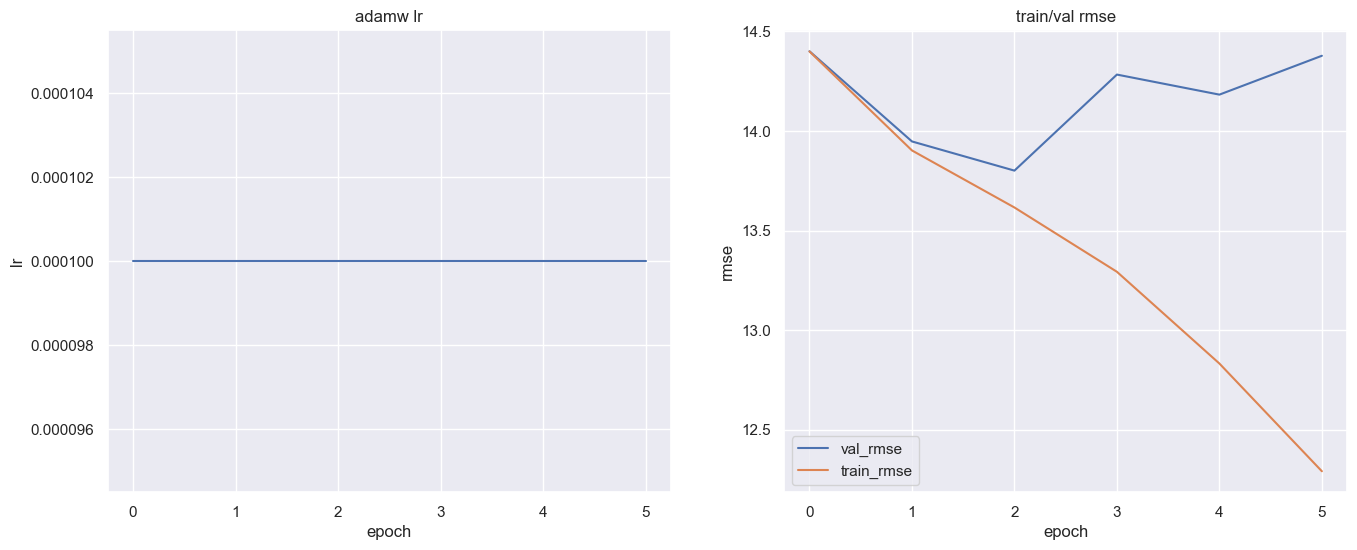

In [42]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import seaborn as sns

path = glob.glob(f'./output/logs/lightning_logs/version_2/events*')[0]
event_acc = EventAccumulator(path, size_guidance={'scalars': 0})
event_acc.Reload()

scalars = {}
for tag in event_acc.Tags()['scalars']:
    events = event_acc.Scalars(tag)
    scalars[tag] = [event.value for event in events]

for k, v in scalars.items():
    print(k, v)
sns.set()

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(range(len(scalars['lr-AdamW'])), scalars['lr-AdamW'])
plt.xlabel('epoch')
plt.ylabel('lr')
plt.title('adamw lr')

plt.subplot(1, 2, 2)
# plt.plot(scalars['epoch'], scalars['train_loss'], label='train_loss')
plt.plot(range(len(scalars['val_rmse'])), scalars['val_rmse'], label='val_rmse')
plt.plot(range(len(scalars['train_rmse'])), scalars['train_rmse'], label='train_rmse')
plt.legend()
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.title('train/val rmse')
plt.show()

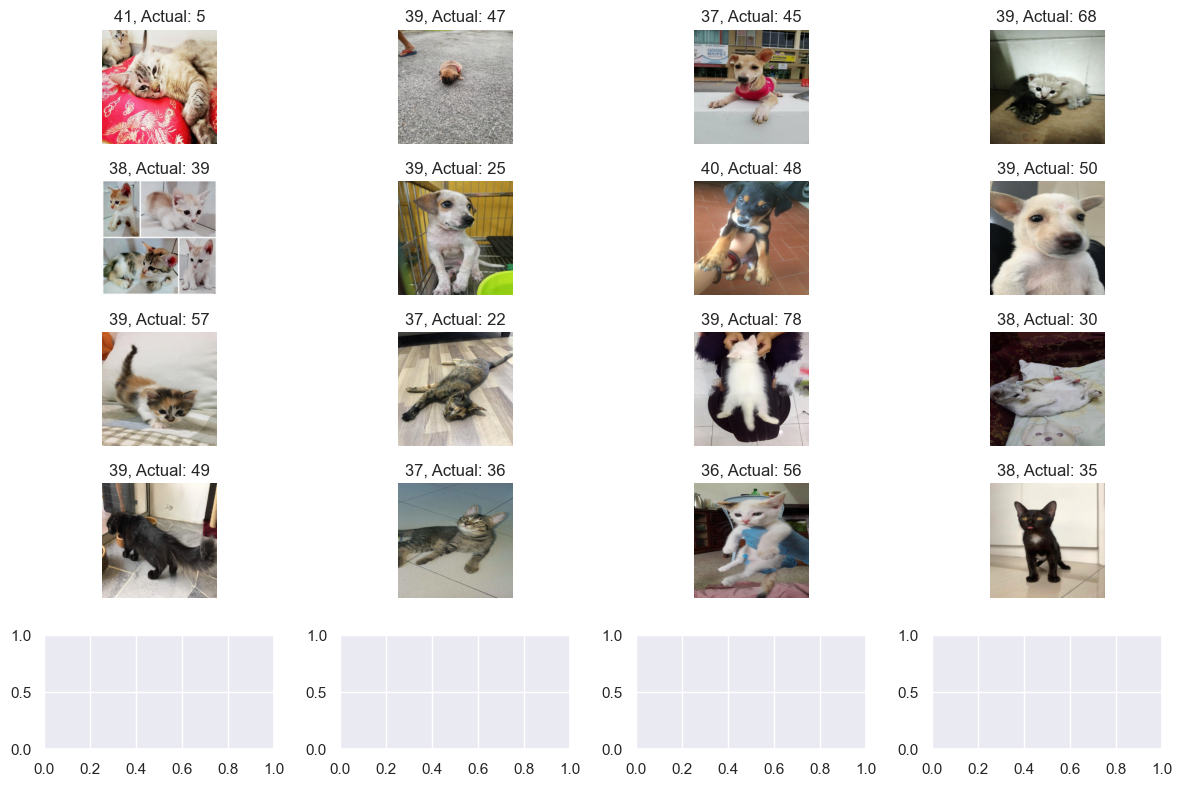

In [46]:
cols = 4

model = PawpularityModel(model_name=model_name, pretrained=False)
checkpoint = torch.load("output/model_checkpoints/best_loss.ckpt")

model.load_state_dict(checkpoint['state_dict'])
model.to("cpu")

data_module = PetFinderDataModule(df_train, df_val, df_test, train_dir=TRAIN_DIR, val_dir=TRAIN_DIR, test_dir=TEST_DIR, batch_size=16, image_size=384)
dataiter = iter(data_module.val_dataloader())
batch = next(dataiter)
image_ids, features, images, labels = batch
rows = len(images) // cols + 1

figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
for i in range(len(images)):
    image = images[i]
    label = labels[i]
    feature = features[i]
    with torch.no_grad():
        prediction = model(torch.as_tensor(image, dtype=torch.float32).unsqueeze(0), feature.unsqueeze(0))
        prediction = prediction.sigmoid().detach().numpy()[0][0] * 100

    ax.ravel()[i].imshow(image.permute(1, 2, 0))
    ax.ravel()[i].set_axis_off()
    ax.ravel()[i].set_title(f"{round(prediction)}, Actual: {label}")

plt.tight_layout(pad=1)
plt.show()